In [21]:
basedir = '/home/jun/sortrun/'

In [22]:
import os
import re
from typing import Tuple
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib.lines import Line2D


def do_normalization(bench: str, matrix: np.ndarray, eventList: list) -> np.ndarray:
    path = os.path.join(basedir, bench, "m5out")
    os.chdir(path)
    numbers = []
    event_counts = {}
    i = int()
    with open('stats.txt', 'r') as f:
        lines = f.readlines()
    for line in lines:
        if "simInsts" in line:
            i = int(line.split()[1])/1000
    for event in eventList:
        count = sum(event in line for line in lines)
        event_counts[event] = count
    for event in eventList:
        for line in lines:
            if event in line and ('total' in line or event_counts[event] == 1):
                numbers.append(int(line.split()[1])/i)
                break
    return matrix / np.array(numbers)


def find_top5_asymmetry(data: np.ndarray):
    asymmetry_matrix = np.abs(np.triu(data, k=1) - np.tril(data, k=-1).T)
    asymmetry_combinations = np.triu(asymmetry_matrix, k=1)
    top5_indices = np.unravel_index(np.argsort(
        asymmetry_combinations, axis=None)[-5:], asymmetry_combinations.shape)
    return top5_indices


def find_top10_asymmetry(data: np.ndarray):
    asymmetry_matrix = np.abs(np.triu(data, k=1) - np.tril(data, k=-1).T)
    asymmetry_combinations = np.triu(asymmetry_matrix, k=1)
    top10_indices = np.unravel_index(np.argsort(
        asymmetry_combinations, axis=None)[-10:], asymmetry_combinations.shape)
    return top10_indices


def draw_heatmap(title: str, data: np.ndarray, eventList: list):
    xticklabels = eventList
    yticklabels = list(reversed(eventList))
    matrix_flipped = np.flipud(data)
    ax = sns.heatmap(matrix_flipped, xticklabels=xticklabels,
                     yticklabels=yticklabels)

    plt.gcf().set_size_inches(10, 8)

    line = Line2D([matrix_flipped.shape[1], 0], [
        0, matrix_flipped.shape[0]], color='red')
    plt.gca().add_line(line)
    plt.title(title)
    plt.show()


def draw_heatmap_group(comment: str, m16: np.ndarray, m32: np.ndarray, m64: np.ndarray, m256: np.ndarray, eventList: list) -> None:
    xticklabels = eventList
    yticklabels = list(reversed(eventList))
    matrix_flipped1 = np.flipud(m16)
    matrix_flipped2 = np.flipud(m32)
    matrix_flipped3 = np.flipud(m64)
    matrix_flipped4 = np.flipud(m256)

    fig, axs = plt.subplots(2, 2)

    sns.heatmap(matrix_flipped1, ax=axs[0, 0], xticklabels=xticklabels,
                yticklabels=yticklabels)
    sns.heatmap(matrix_flipped2, ax=axs[0, 1], xticklabels=xticklabels,
                yticklabels=yticklabels)
    sns.heatmap(matrix_flipped3, ax=axs[1, 0], xticklabels=xticklabels,
                yticklabels=yticklabels)
    sns.heatmap(matrix_flipped4, ax=axs[1, 1], xticklabels=xticklabels,
                yticklabels=yticklabels)

    fig.autofmt_xdate(rotation=45)

    axs[0, 0].set_title('Time Window: 16 cycle')
    axs[0, 1].set_title('Time Window: 32 cycle')
    axs[1, 0].set_title('Time Window: 64 cycle')
    axs[1, 1].set_title('Time Window: 256 cycle')

    fig.suptitle(comment, x=0.45, y=0.95, fontsize=16)
    plt.gcf().set_size_inches(17, 15)
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    for ax in axs.flatten():
        line = Line2D([matrix_flipped1.shape[1], 0], [
                      0, matrix_flipped1.shape[0]], color='white')
        ax.add_line(line)
        # ax.xaxis.labelpad = 1.0
        # ax.tick_params(axis='x', pad=0)

    import matplotlib.transforms as mtransforms
    for ax in axs.flatten():
        labels = ax.get_xticklabels()
        for label in labels:
            trans = mtransforms.Affine2D().translate(0.5, 23.3) + ax.transData
            label.set_transform(trans)

    plt.show()


def analyze(bench: str, normalize: bool = False) -> Tuple:
    map = {}
    top_pairs = []

    path = os.path.join(basedir, bench)
    os.chdir(path)

    with open(bench+'.out', 'r') as f:
        lines = []
        text = ""
        for line in f:
            if line.startswith('recorded events:'):
                eventList = line.split(":")[1].strip().split(" ")
            lines.append(line)
        text = "".join(lines)

    match1 = re.search(r"Executed instructions: (\d+)", text)
    if match1:
        executed_instructions = int(match1.group(1))
        i = executed_instructions / 1000
    else:
        print("No executed_instructions found.")

    print(bench + ": ", executed_instructions)

    match3 = re.search(r"all events count: (\d+)", text)
    if match3:
        event_count = int(match3.group(1))
    else:
        print("No event_count found.")

    assert len(eventList) == event_count, "event count mismatch"
    map[bench] = event_count
    del event_count

    fd = 'bc16v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m16v1 = np.array(data_list, np.uint64) / i

    fd = 'bc16v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m16v2 = np.array(data_list, np.uint64) / i

    fd = 'bc32v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m32v1 = np.array(data_list, np.uint64) / i

    fd = 'bc32v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m32v2 = np.array(data_list, np.uint64) / i

    fd = 'bc64v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m64v1 = np.array(data_list, np.uint64) / i

    fd = 'bc64v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m64v2 = np.array(data_list, np.uint64) / i

    fd = 'bc128v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m128v1 = np.array(data_list, np.uint64) / i

    fd = 'bc128v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m128v2 = np.array(data_list, np.uint64) / i

    fd = 'bc256v1.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m256v1 = np.array(data_list, np.uint64) / i

    fd = 'bc256v2.txt'
    with open(fd, 'r') as file:
        data = file.read()
    data_list = eval(data)
    m256v2 = np.array(data_list, np.uint64) / i

    m32v1 = m32v1 + m16v1
    m32v2 = m32v2 + m16v2
    m64v1 = m64v1 + m32v1
    m64v2 = m64v2 + m32v2
    m128v1 = m128v1 + m64v1
    m128v2 = m128v2 + m64v2
    m256v1 = m256v1 + m128v1
    m256v2 = m256v2 + m128v2

    if normalize == True:
        for i, m in enumerate([m16v1, m16v2, m32v1, m32v2, m64v1, m64v2, m128v1, m128v2, m256v1, m256v2]):
            m = do_normalization(bench, m, eventList)
            if i == 0:
                m16v1 = m
            elif i == 1:
                m16v2 = m
            elif i == 2:
                m32v1 = m
            elif i == 3:
                m32v2 = m
            elif i == 4:
                m64v1 = m
            elif i == 5:
                m64v2 = m
            elif i == 6:
                m128v1 = m
            elif i == 7:
                m128v2 = m
            elif i == 8:
                m256v1 = m
            elif i == 9:
                m256v2 = m

    asymmetry_results = {}
    asymmetry_results[bench] = find_top5_asymmetry(m256v2)
    indices = asymmetry_results[bench]
    top_pairs = [(eventList[i], eventList[j]) for i, j in zip(*indices)]

    max_index = np.unravel_index(np.argmax(m16v2, axis=None), m16v2.shape)
    top16 = (eventList[max_index[0]], eventList[max_index[1]])

    max_index = np.unravel_index(np.argmax(m32v2, axis=None), m32v2.shape)
    top32 = (eventList[max_index[0]], eventList[max_index[1]])

    max_index = np.unravel_index(np.argmax(m64v2, axis=None), m64v2.shape)
    top64 = (eventList[max_index[0]], eventList[max_index[1]])

    max_index = np.unravel_index(np.argmax(m128v2, axis=None), m128v2.shape)
    top128 = (eventList[max_index[0]], eventList[max_index[1]])

    max_index = np.unravel_index(np.argmax(m256v2, axis=None), m256v2.shape)
    top256 = (eventList[max_index[0]], eventList[max_index[1]])

    tops = zip("top16, top32, top64, top128, top256".split(", "),
               [top16, top32, top64, top128, top256])
    m = zip("m16v2, m32v2, m64v2, m128v2, m256v2".split(
        ", "), [m16v2, m32v2, m64v2, m128v2, m256v2])

    return {key: value for (key, value) in m}, top_pairs, dict(tops), eventList

In [23]:
benchlist = '''stlintrosort stlstablesort stlheapsort
 combsort libcqsort itermergesort paulheapsort paulquicksort paulmergesort'''.split()

comment = {

}

stlintrosort:  13439261


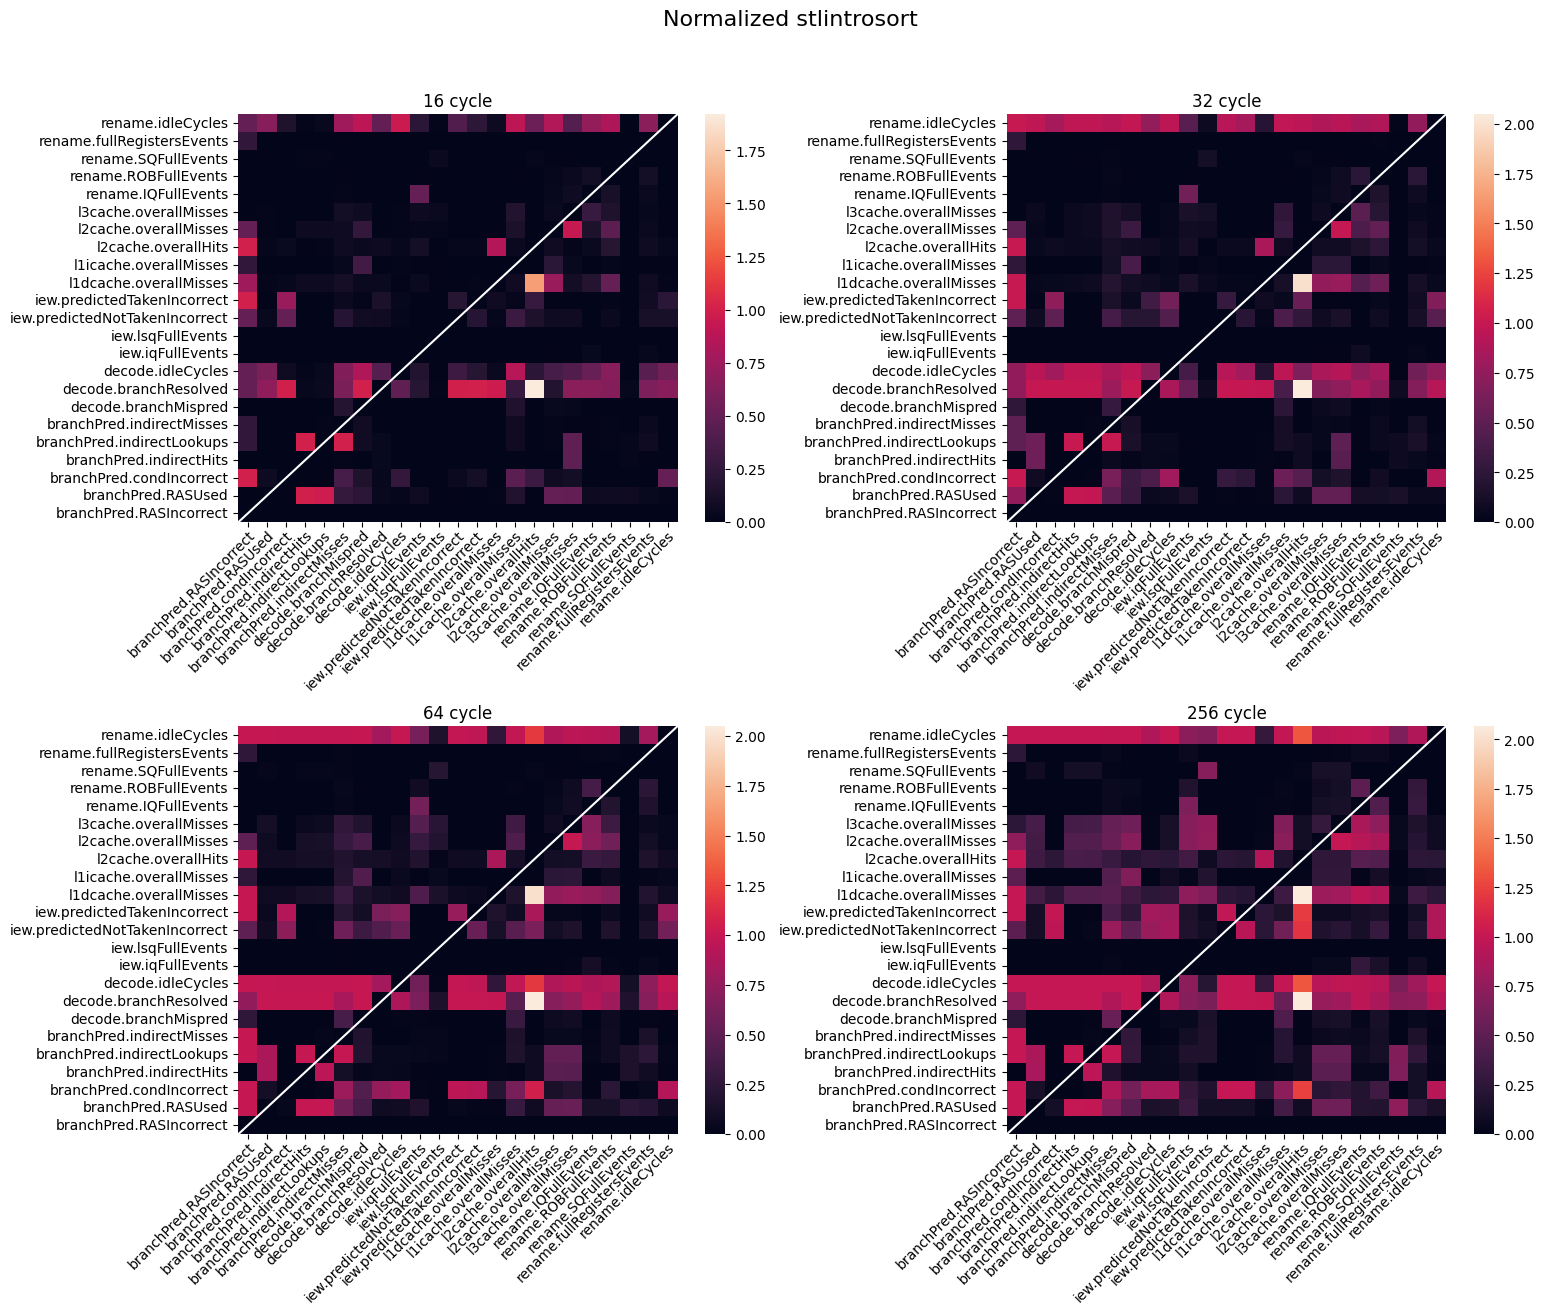

stlstablesort:  18468305


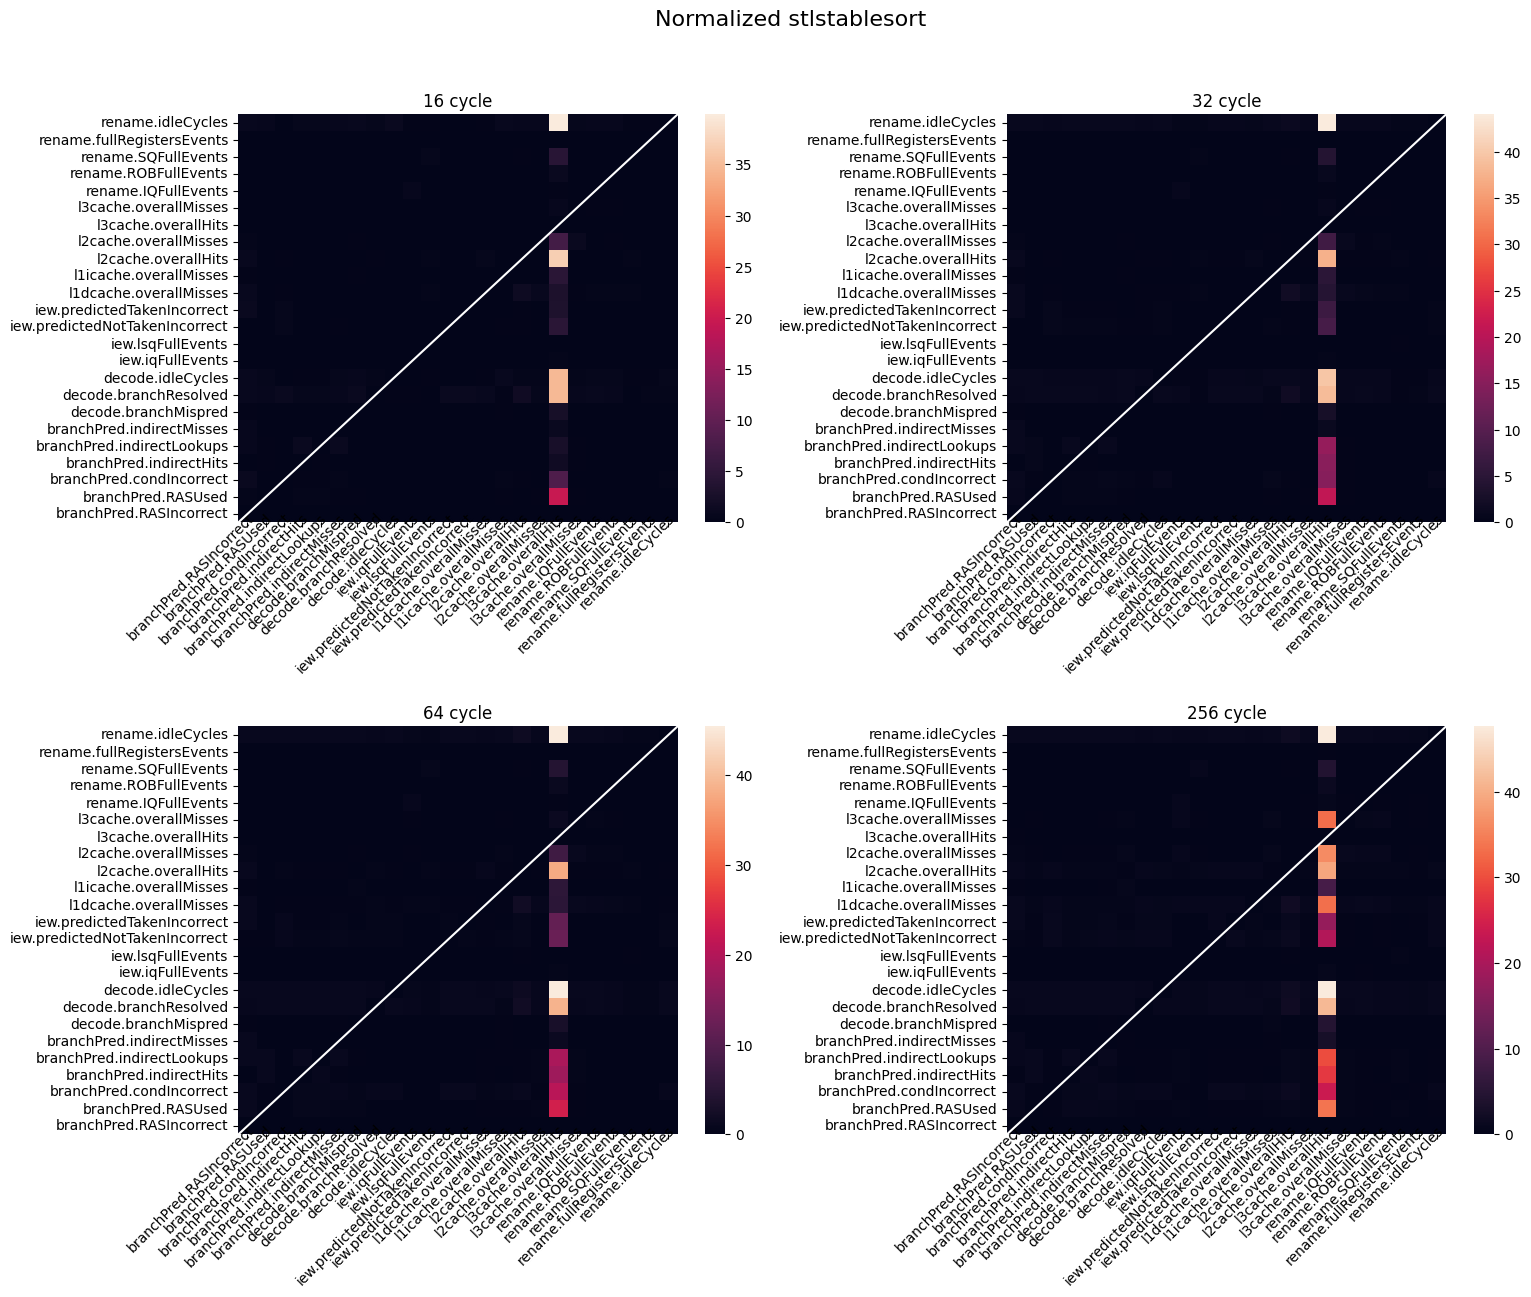

stlheapsort:  28940994


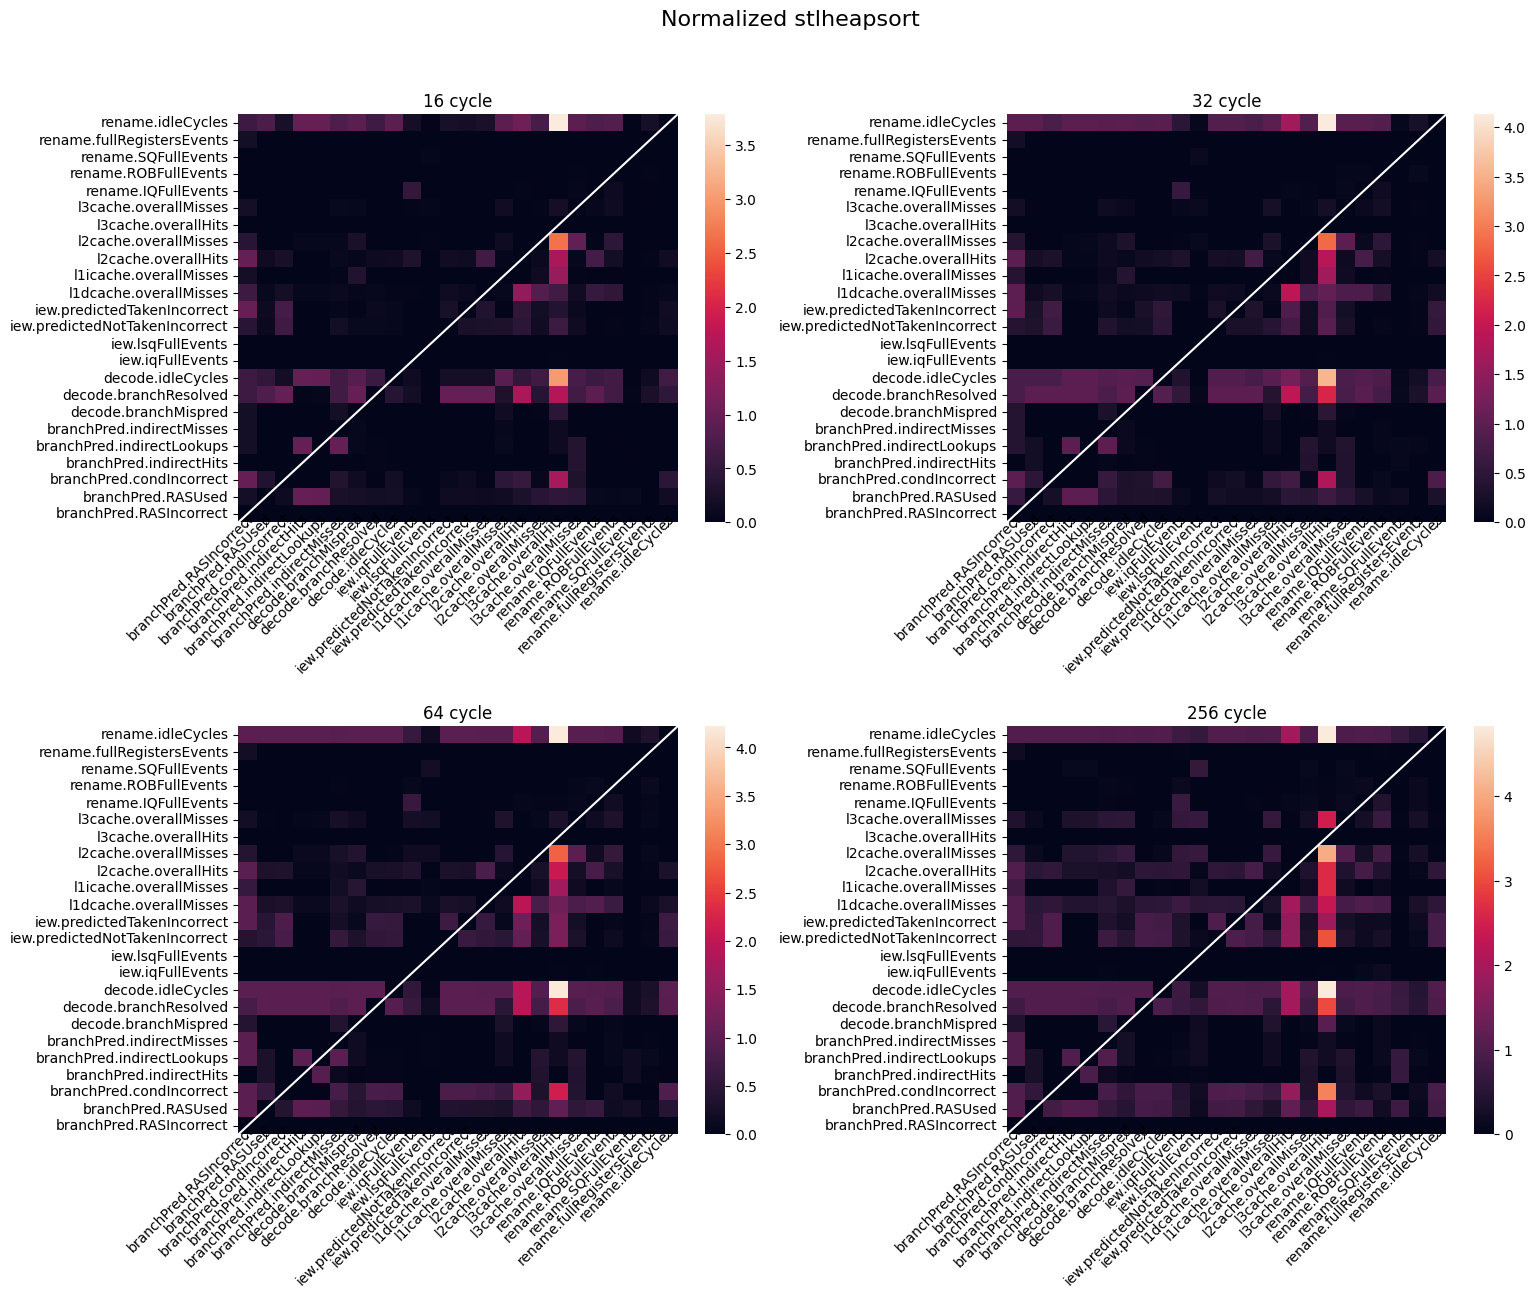

combsort:  19808338


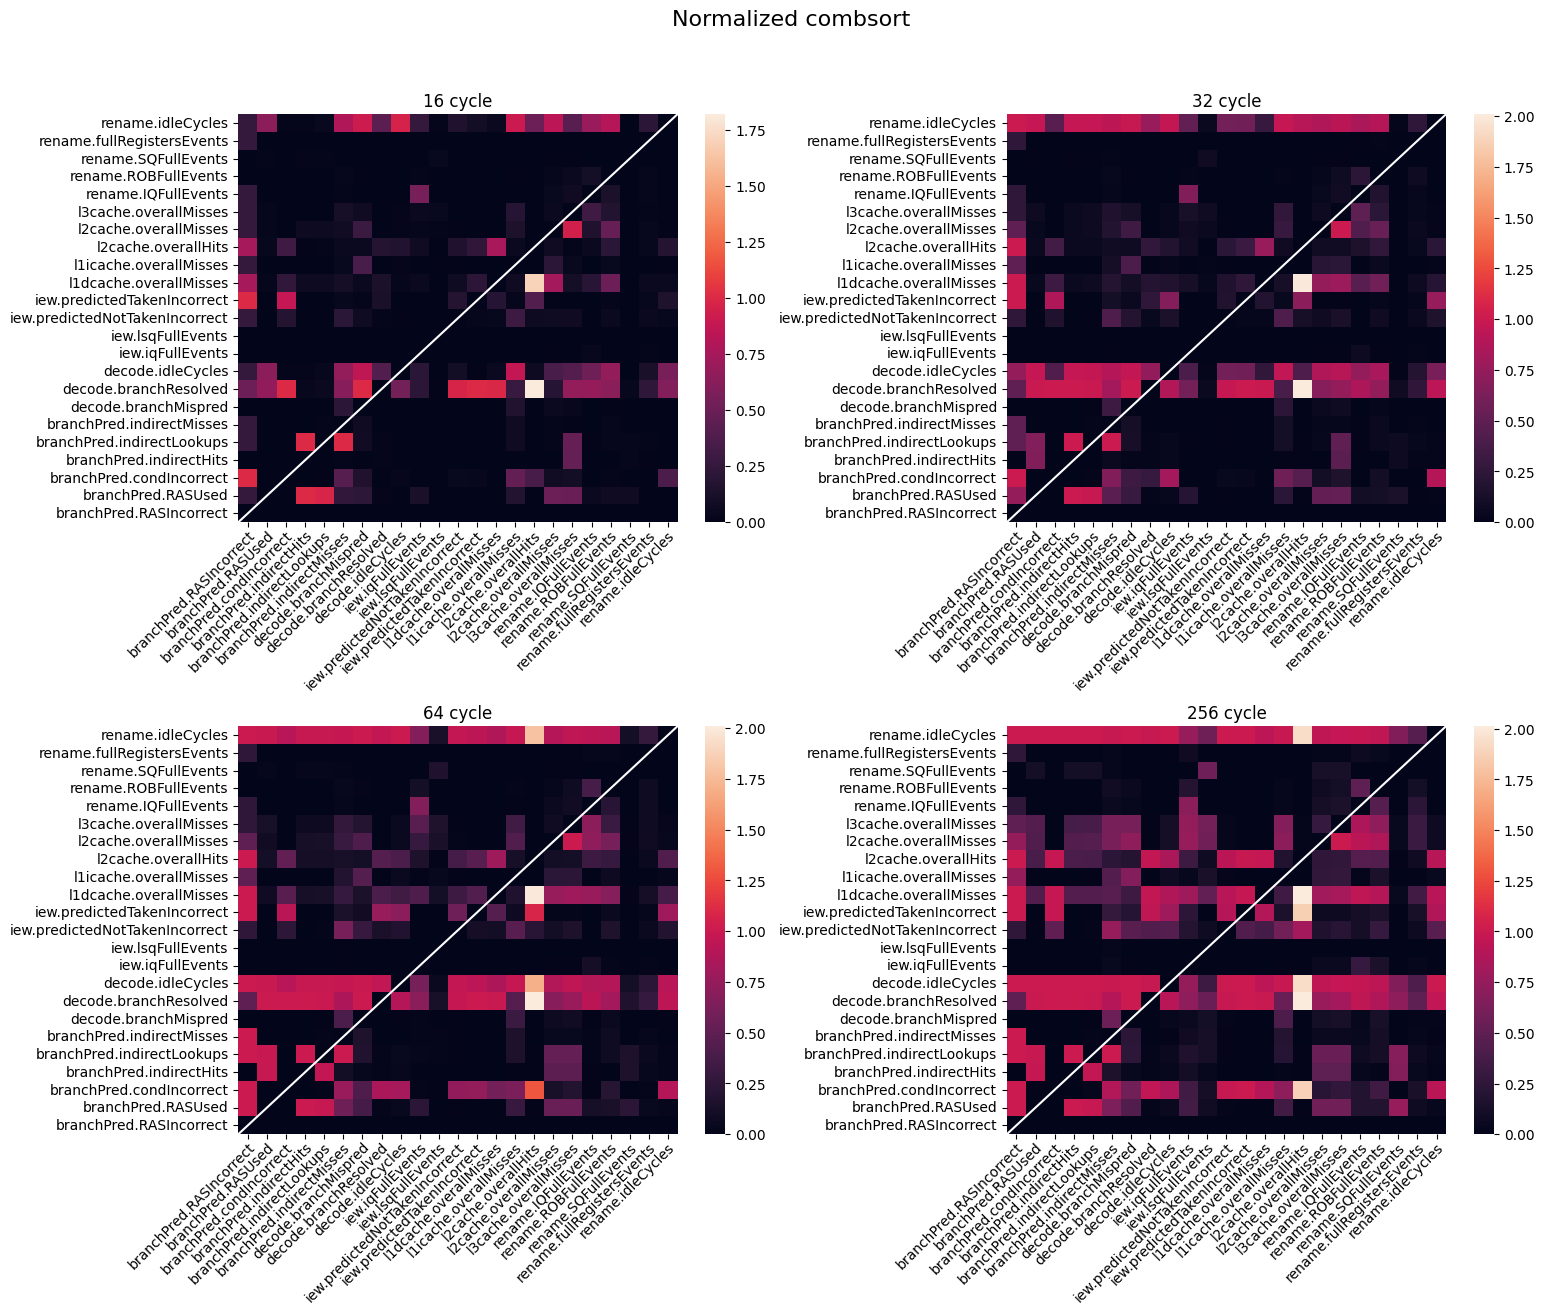

libcqsort:  20369379


KeyboardInterrupt: 

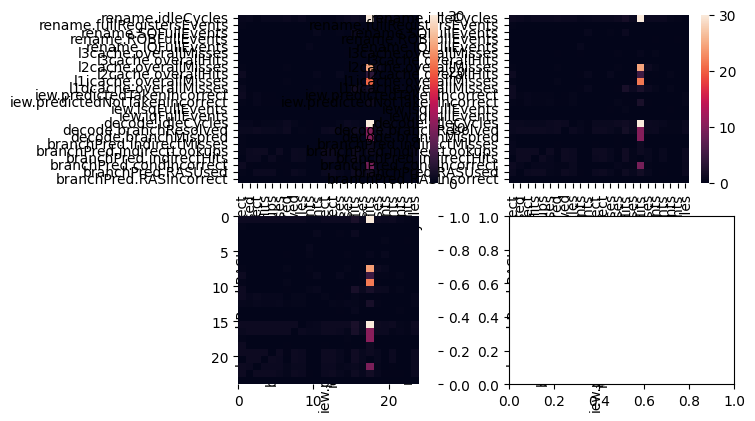

In [24]:
for bench in benchlist:
    m, p, t, e = analyze(bench, normalize=True)
    draw_heatmap_group("Normalized "+bench, m['m16v2'],
                       m['m32v2'], m['m64v2'], m['m256v2'], e)

In [ ]:
# benchlist = '''libcqsort'''.split()
tops = {}
matrixs = {}
top_pairs = {}
events = {}


for bench in benchlist:
    matrixs[bench], top_pairs[bench], tops[bench], events[bench] = analyze(
        bench)

# for bench in benchlist:
#     draw_heatmap(bench+", 16 cycle", matrixs[bench]['m16v2'], events[bench])
#     draw_heatmap(bench+", 256 cycle", matrixs[bench]['m256v2'], events[bench])

In [ ]:
tops_n = {}
matrixs_n = {}
top_pairs_n = {}
events = {}

for bench in benchlist:
    matrixs_n[bench], top_pairs_n[bench], tops_n[bench], events[bench] = analyze(
        bench, normalize=True)

for bench in benchlist:
    draw_heatmap(bench+", normalized, 16 cycle",
                 matrixs_n[bench]['m16v2'], events[bench])
    draw_heatmap(bench+", normalized, 256 cycle",
                 matrixs_n[bench]['m256v2'], events[bench])

In [ ]:
for bench in benchlist:
    print(bench+"-normalized")
    pprint(tops[bench])
    print("top 5 pairs")
    pprint(top_pairs[bench])
    # newline
print()

In [ ]:
count = dict()
for bench in benchlist:
    for pair in top_pairs[bench]:
        count[pair] = count.get(pair, 0) + 1

pprint(count)

In [ ]:
results = []

for bench in benchlist:
    with open(os.path.join(basedir, bench, bench+".out"), 'r') as file:
        for line in file:
            match = re.search(
                r'Simulated time \(ms\): (\d+\.\d+)', line)
            if match:
                results.append((bench, float(match.group(1))))

results = sorted(results, key=lambda x: x[1])

for bench, time in results:
    print(f"{bench}: {time}")